<a href="https://colab.research.google.com/github/sebastianrdz/brown-bag-machine-learning-sentiment-analysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download

https://www.kaggle.com/code/amirhoseinsedaghati/sentiment-analysis-on-reviews-mchcnn-bert-textblob

## Connect to Google Drive
For this to work, you must have especify your working directory within your google dirve. You must also have the "IMDB Dataset.csv" in youd directory. You can download it from [Kaggle here.](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Machine Learning


In [ ]:
%cd "/content/gdrive/MyDrive/Machine Learning"
!ls

/content/gdrive/MyDrive/Machine Learning
 GRU.sav	     notebookfbcaf0d33e.ipynb		     Reto_Tokenizer.ipynb
'IMDB Dataset.csv'  'Presentación de avance del reto.pptx'  'Untitled presentation.gslides'


## Import

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-r6nqncck
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-r6nqncck
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


In [ ]:
import joblib
import nltk
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import re
import tensorflow as tf
import visualkeras # pip install above should run
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, SpatialDropout1D, GRU
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.utils import plot_model
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tensorflow import keras

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Structure Visualization

In [ ]:
# read IMDB Dataset
reviews = pd.read_csv("IMDB Dataset.csv")

In [ ]:
# visualize the first 5 reviews
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# get general data info and structure
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# visualize the first review
reviews['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Data Cleanup

In [ ]:
stopwords_list = set(stopwords.words('english'))
clean = re.compile('<.*?>')

def cleanReview(review):
    review = review.lower() # turn to lowercase the review
    review = clean.sub('', review) # remove html tags
    review = re.sub('[^a-zA-Z]', ' ', review) # remove all charaters that are not letters
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review) # remove 1 charecter words (i, a, s, etc.)
    review = re.sub(r'\s+', ' ', review) # adjust spacing between words

    # Remove Stopwords (me, i, him, it, is, and, etc.)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    review = pattern.sub('', review)

    return review

In [ ]:
result = []
for review in reviews['review']:
  result.append(cleanReview(review))

In [ ]:
reviews['review'] = result

In [ ]:
reviews['review'][0]

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skill

## Text Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(reviews['review'].values)
word_index = tokenizer.word_index

## Data Split
Here we split the data into two categotires, train and test.

- `X_train` reviews used for training,
- `Y_train` sentiments used for training,
- `X_test` reviews used for testing,
- `Y_test` sentiments used for testing,

In [ ]:
X = tokenizer.texts_to_sequences(reviews['review'].values)
X = pad_sequences(X, maxlen=250)

Y = pd.get_dummies(reviews['sentiment']).values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

## Model

In [ ]:
# Define GRU model
gruModel = Sequential()
gruModel.add(Embedding(50000, 100, input_length=X.shape[1]))
gruModel.add(SpatialDropout1D(0.2))
gruModel.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gruModel.add(Dense(2, activation='softmax'))
gruModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gruModel.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 100)          0         
 alDropout1D)                                                    
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5060802 (19.31 MB)
Trainable params: 5060802 (19.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


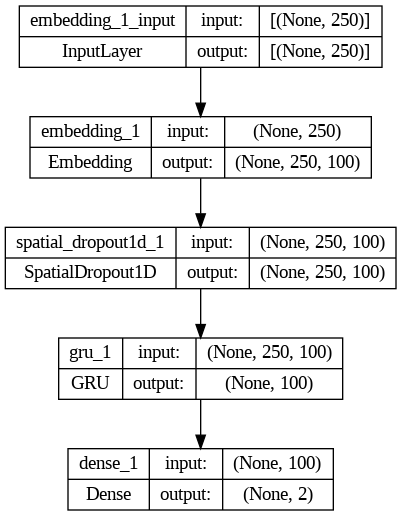

In [ ]:
plot_model(gruModel, to_file='gru_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
gruHistory = gruModel.fit(X_train, Y_train, epochs=14, batch_size=64, validation_split=0.2)
joblib.dump(gruModel, 'GRU.sav')

Epoch 1/14
500/500 [==============================] - 368s 735ms/step - loss: 0.1657 - accuracy: 0.9396 - val_loss: 0.2953 - val_accuracy: 0.8821
Epoch 2/14
500/500 [==============================] - 372s 744ms/step - loss: 0.0834 - accuracy: 0.9721 - val_loss: 0.4027 - val_accuracy: 0.8784
Epoch 3/14
500/500 [==============================] - 379s 757ms/step - loss: 0.0495 - accuracy: 0.9834 - val_loss: 0.4359 - val_accuracy: 0.8739
Epoch 4/14
500/500 [==============================] - 375s 751ms/step - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.5657 - val_accuracy: 0.8769
Epoch 5/14
500/500 [==============================] - 374s 747ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.6672 - val_accuracy: 0.8749
Epoch 6/14
500/500 [==============================] - 375s 749ms/step - loss: 0.0171 - accuracy: 0.9940 - val_loss: 0.6900 - val_accuracy: 0.8620
Epoch 7/14
500/500 [==============================] - 369s 739ms/step - loss: 0.0157 - accuracy: 0.9949 - val_loss: 0.7234 -

['GRU.sav']

In [ ]:
gruModel = joblib.load('GRU.sav')
acc = gruModel.evaluate(X_test,Y_test)
print('GRU Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

313/313 [==============================] - 33s 102ms/step - loss: 0.7907 - accuracy: 0.8695
GRU Test set
  Loss: 0.791
  Accuracy: 0.869


## Plot

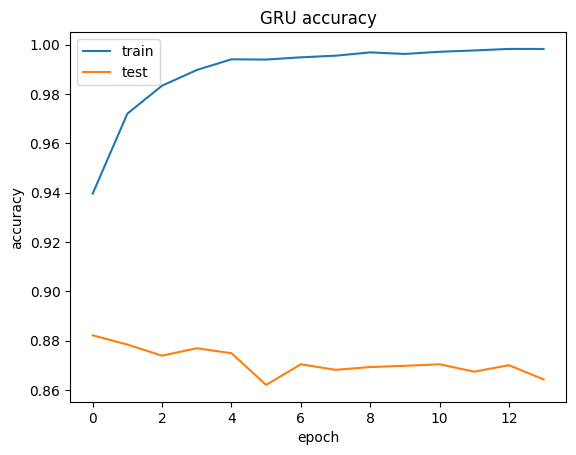

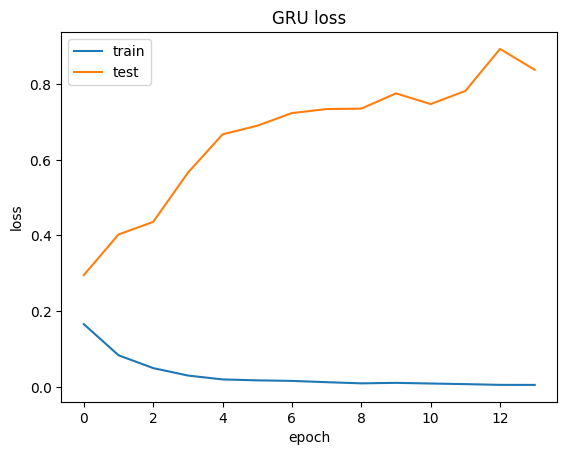

In [ ]:
plt.plot(gruHistory.history['accuracy'])
plt.plot(gruHistory.history['val_accuracy'])
plt.title('GRU accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(gruHistory.history['loss'])
plt.plot(gruHistory.history['val_loss'])
plt.title('GRU loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()